In [1]:
import sys
sys.path.append('/home/hashmi/ResearchBook/Tracking/Notebooks/Moore')
from central_import import *

figure_directory = '../../../Figures/LinearModel/'
os.makedirs(figure_directory,exist_ok=True)
set_plot_style()

In [2]:
data = pd.read_parquet('../DataBuild/SciFiTrackTrainingData.parquet')

In [3]:
data.head()

,nFTHits,tx,ty,ovtx_x,ovtx_y,eta,phi,chi2perdof,isMatched
0,12,-0.268153,0.021381,-1055.345947,173.193176,2.023796,3.062026,0.294202,True
1,12,-0.253765,0.028007,-877.907959,228.124252,2.074350,3.031673,0.115257,True
2,11,-0.152263,0.003205,-683.974304,15.691412,2.580823,3.120548,0.193786,True
3,11,-0.226330,-0.001189,-605.358765,5.201992,2.191462,-3.136340,0.199351,True
4,11,-0.119891,0.032337,-537.943909,257.031342,2.783041,2.878142,0.197270,True


In [4]:
data['isMatched'].map({True:"True Tracks[1]",False:"Ghost Tracks[0]"}).value_counts(ascending=True,normalize=True)

isMatched
Ghost Tracks[0]    0.040096
True Tracks[1]     0.959904
Name: proportion, dtype: float64

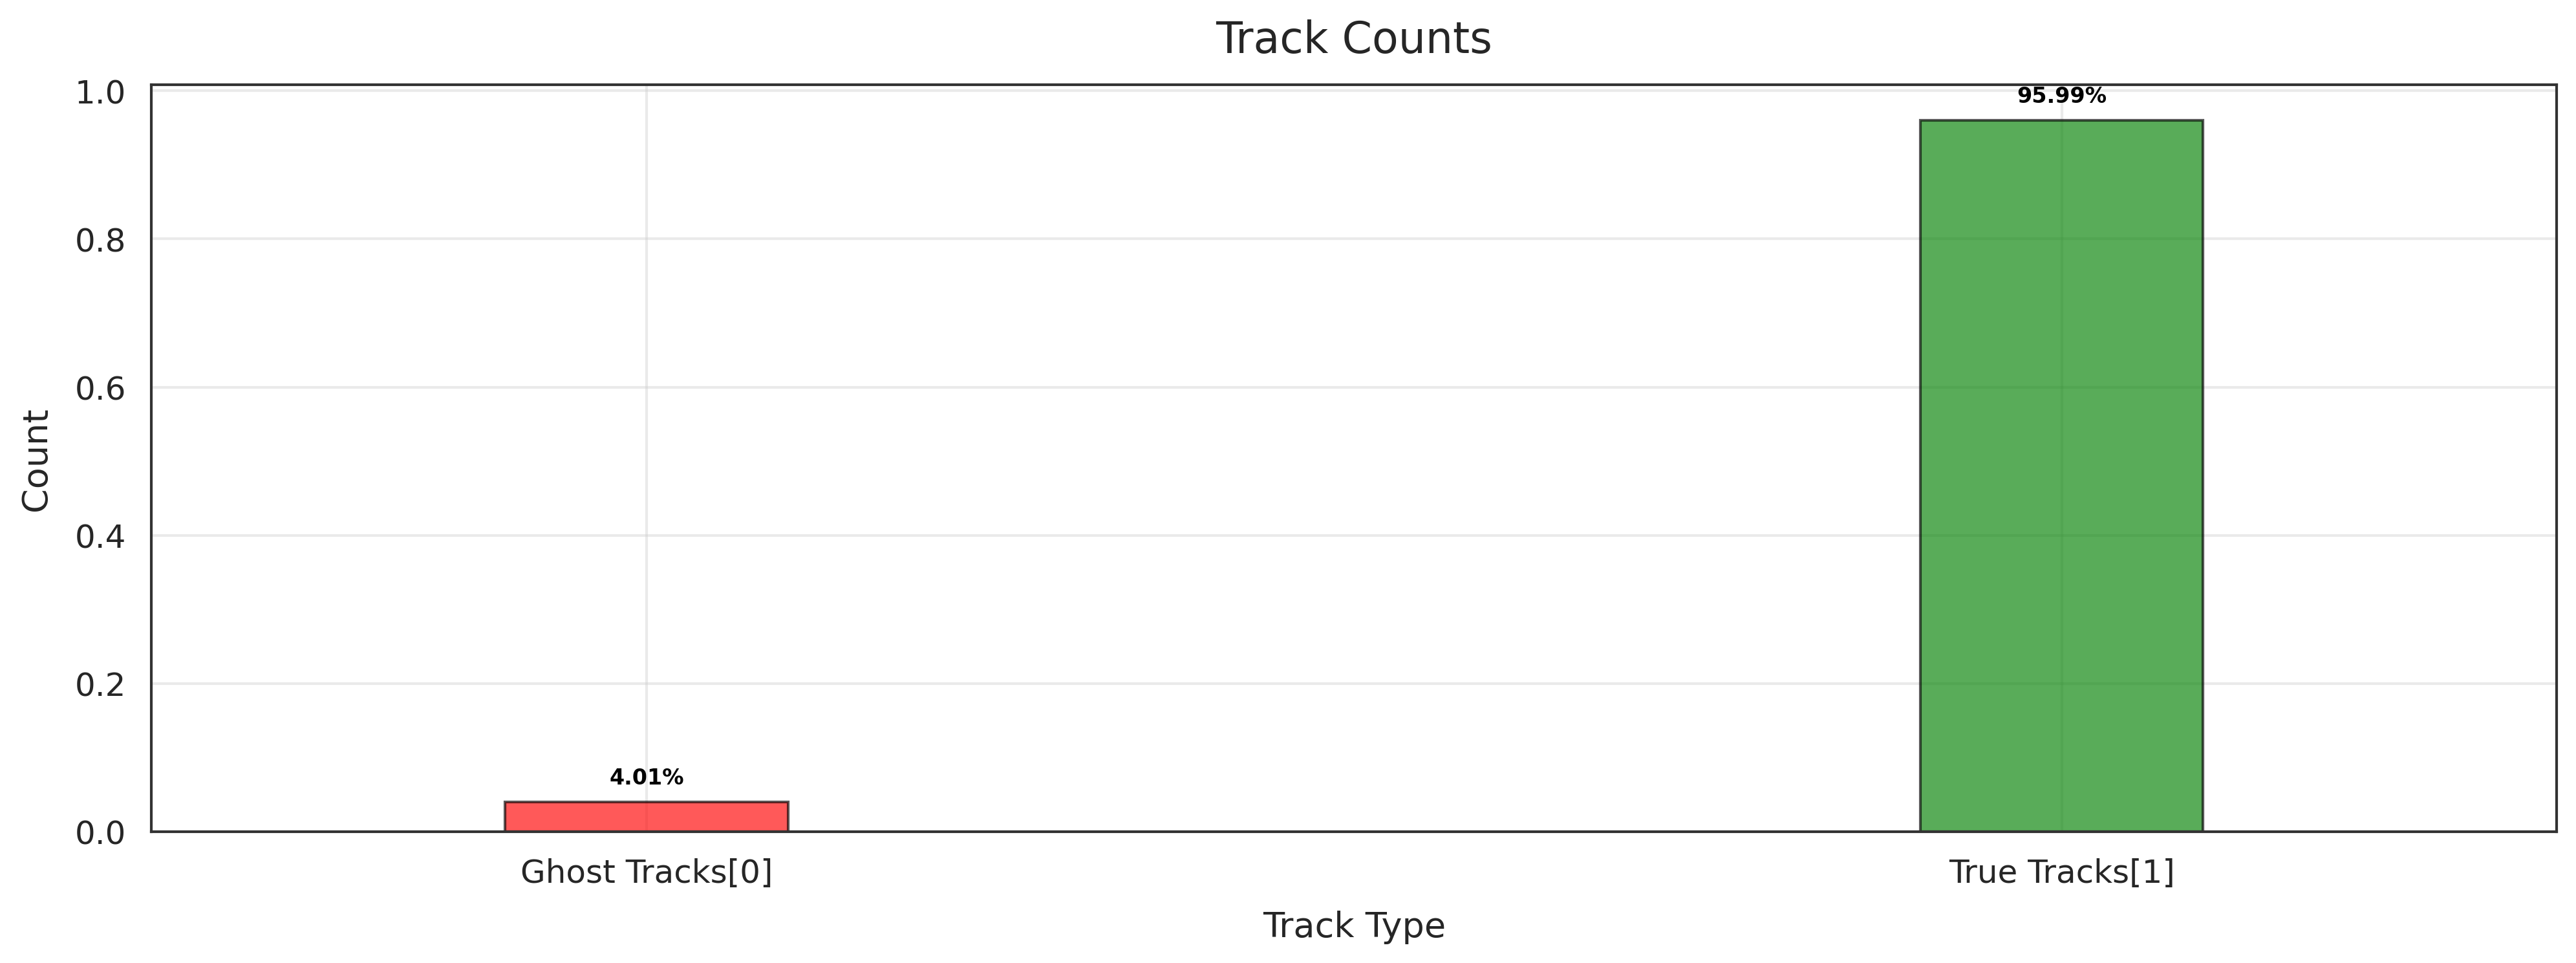

In [5]:
# Plot : Imbalance in Data
ax =data['isMatched'].map({True:"True Tracks[1]",False:"Ghost Tracks[0]"}).value_counts(ascending=True,normalize=True).plot(
    kind='bar',color=['red','green'],alpha=0.65,figsize=(16,5),title='Track Counts',xlabel='Track Type', ylabel='Count',rot=0,width=0.2,edgecolor='black')


for p in ax.patches:
    ax.annotate(f'{round(p.get_height() * 100,2) }%',  # Label the height (Y-value)
                (p.get_x() + p.get_width() / 2., p.get_height()),  # Position the label at the top of the bar
                xytext=(0, 5),  # Offset the label a bit above the bar
                textcoords='offset points',
                ha='center', va='bottom',  # Horizontally and vertically align the text
                color='black', fontsize=8, fontweight='bold')
  
plt.savefig(f"{figure_directory}/SciFi_ClassDistribution.png")

plt.show()

In [6]:
x=data.drop(['isMatched'],axis=1)
y=data['isMatched']

columns=np.array(['SciFiHits','Tx','Ty','X', 'Y','Eta','Phi','Chi2PerDoF'])
x.columns=columns


In [7]:
x.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4245176 entries, 0 to 4245175
Data columns (total 8 columns):
 #   Column      Dtype  
---  ------      -----  
 0   SciFiHits   int32  
 1   Tx          float64
 2   Ty          float64
 3   X           float64
 4   Y           float64
 5   Eta         float64
 6   Phi         float64
 7   Chi2PerDoF  float64
dtypes: float64(7), int32(1)
memory usage: 242.9 MB


In [8]:
#Train-Test-Evaluation Split
x_train,x_temp,y_train,y_temp=train_test_split(x,y,stratify=y,random_state=51)
x_test,x_eval,y_test,y_eval=train_test_split(x_temp,y_temp,stratify=y_temp,random_state=51)

#Preprocessing of Train-Test Data
x_train=pd.DataFrame(scaler.fit_transform(x_train),columns=x.columns)
x_test=pd.DataFrame(scaler.transform(x_test),columns=x.columns)
x_eval=pd.DataFrame(scaler.transform(x_eval),columns=x.columns)
x_train,y_train=sampler.fit_resample(x_train,y_train)
x_eval,y_eval=sampler.fit_resample(x_eval,y_eval)

In [9]:
#Logit Model building and Evaluation
model = LogisticRegression()
model.fit(x_train,y_train)

y_predict = model.predict(x_test)

print("ROC-Score:", round(roc_auc_score(y_test,y_predict)*100,2),"%")
print("F1-Score:", round(f1_score(y_test,y_predict)*100,2),"%")

ROC-Score: 90.56 %
F1-Score: 94.01 %


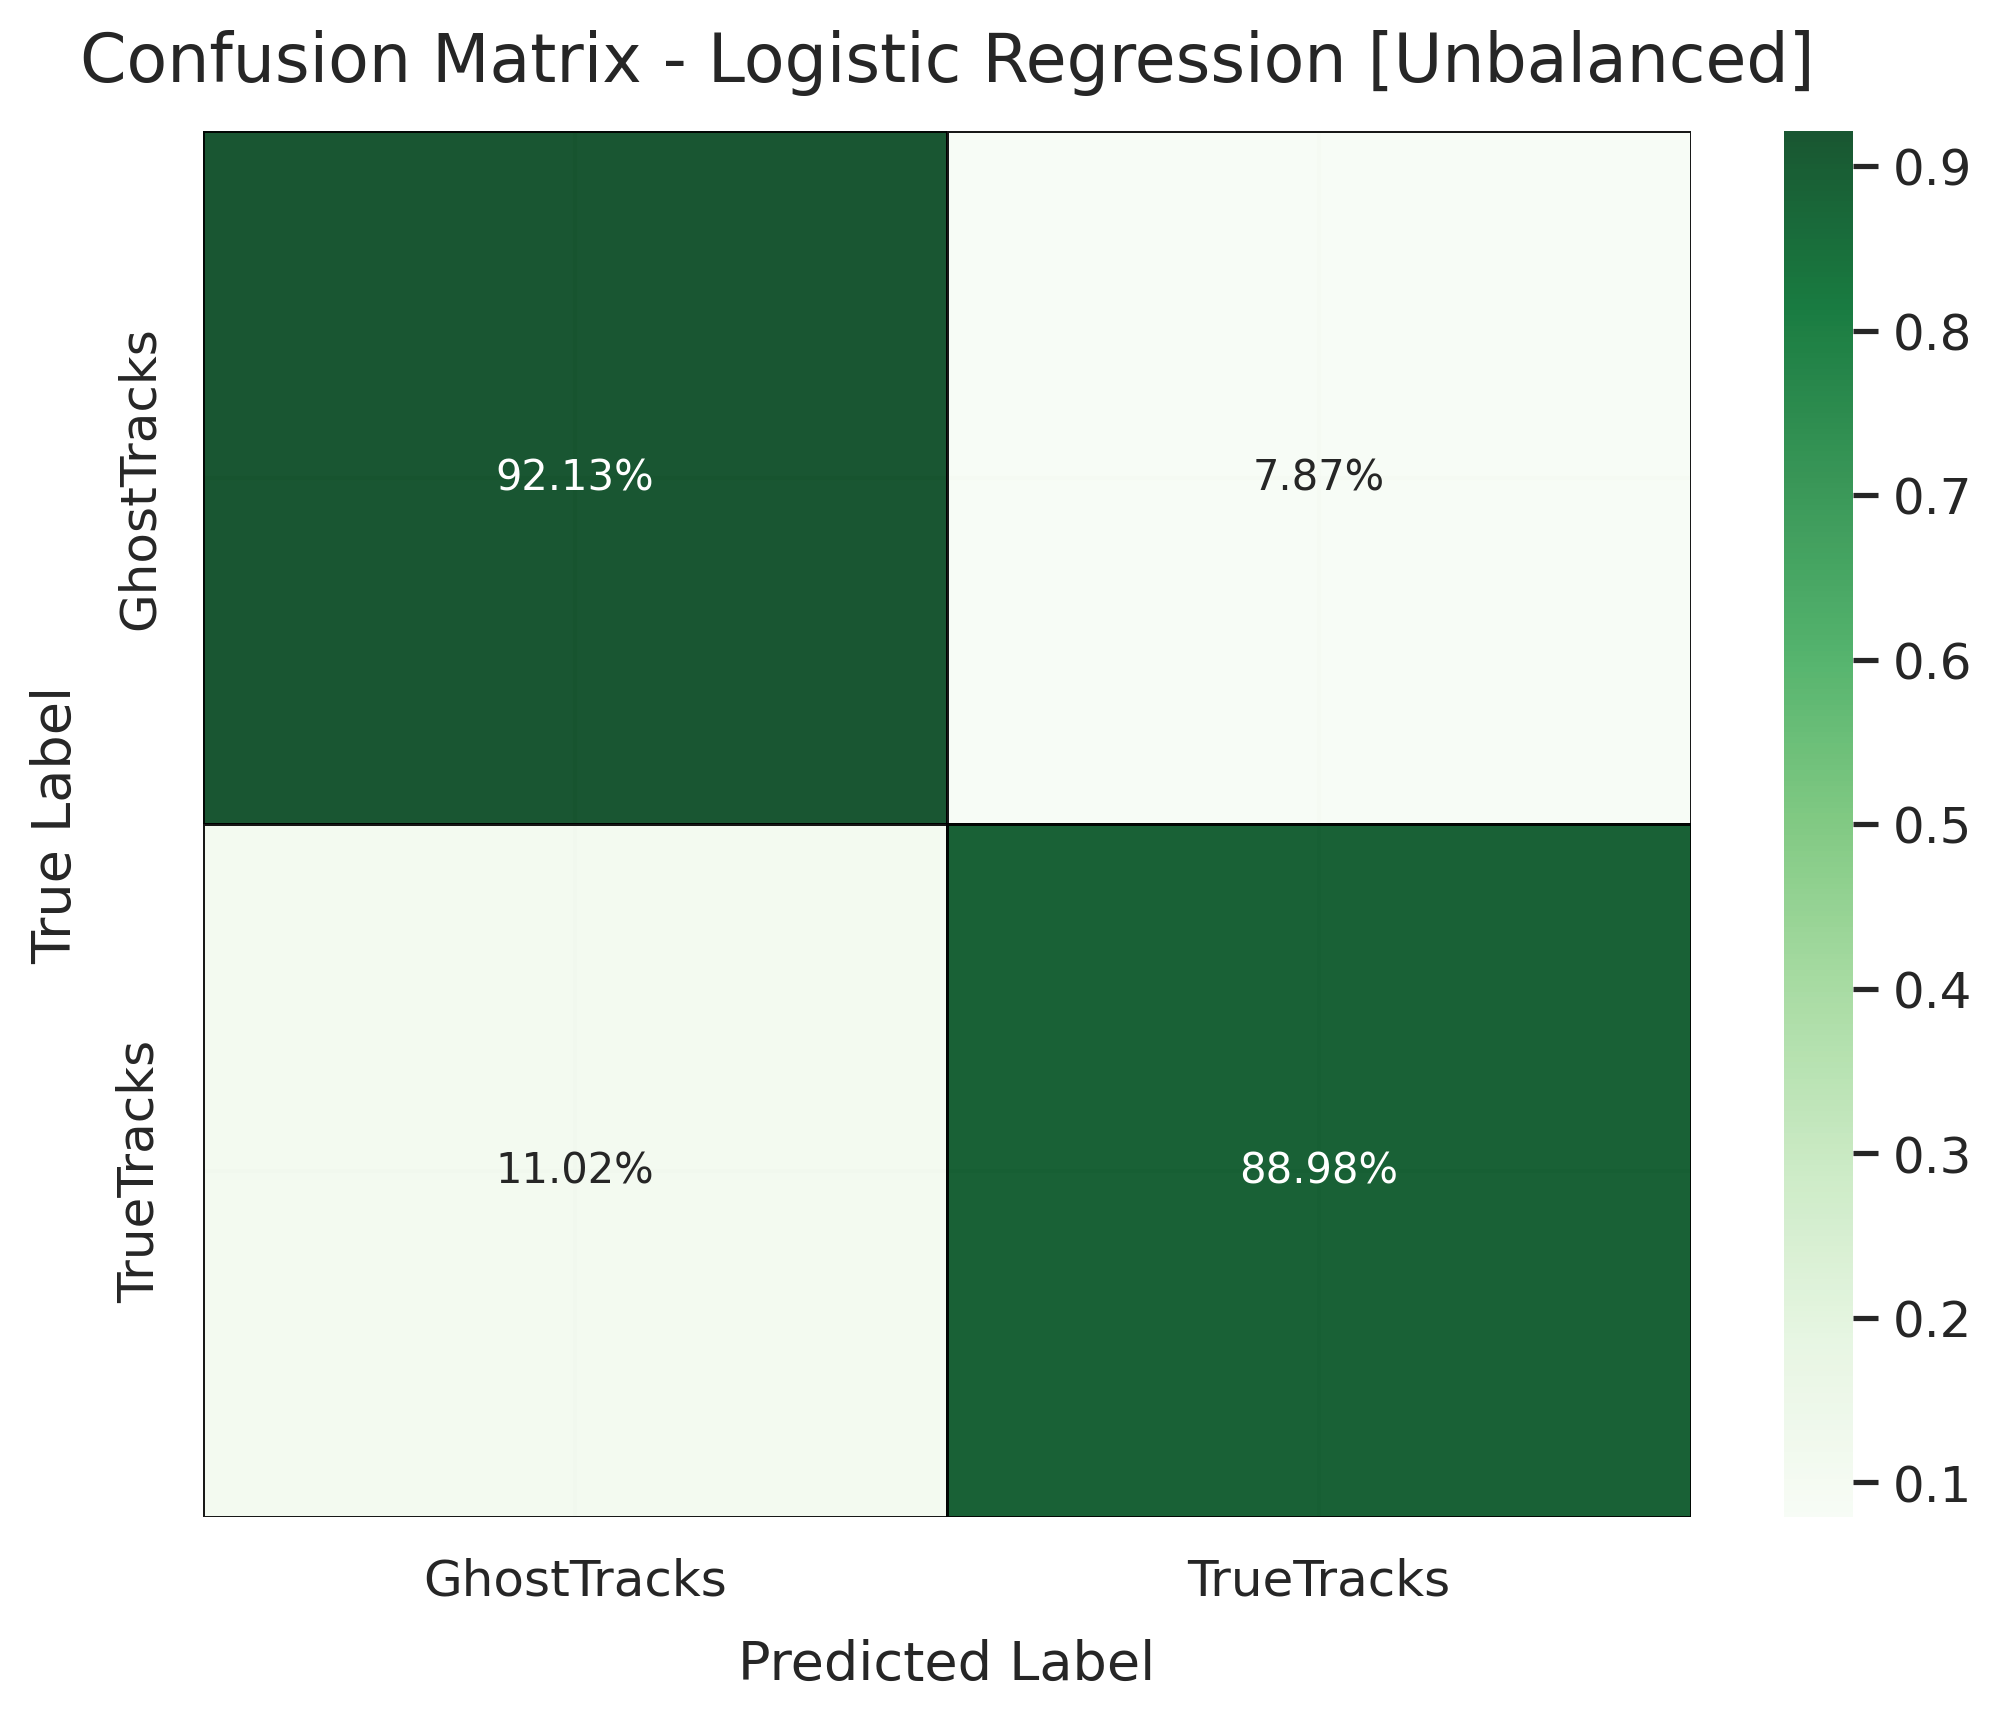

In [10]:
# ConfusionMatrix Test - Unbalanced
y_predict = model.predict(x_test)
plt.figure(figsize=(8,6))
sns.heatmap(confusion_matrix(y_test, y_predict,normalize='true'), xticklabels=['GhostTracks', 'TrueTracks'],yticklabels=['GhostTracks', 'TrueTracks'], fmt='.2%',annot=True, annot_kws={'fontsize': 10}, 
            cmap='Greens',linewidths=0.7,linecolor='black',alpha=0.9)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix - Logistic Regression [Unbalanced]')
plt.savefig(f"{figure_directory}/SciFi_Logit_CM_Unbalanced.png")
plt.show()


ROC-Score: 90.31 %
F1-Score: 90.13 %


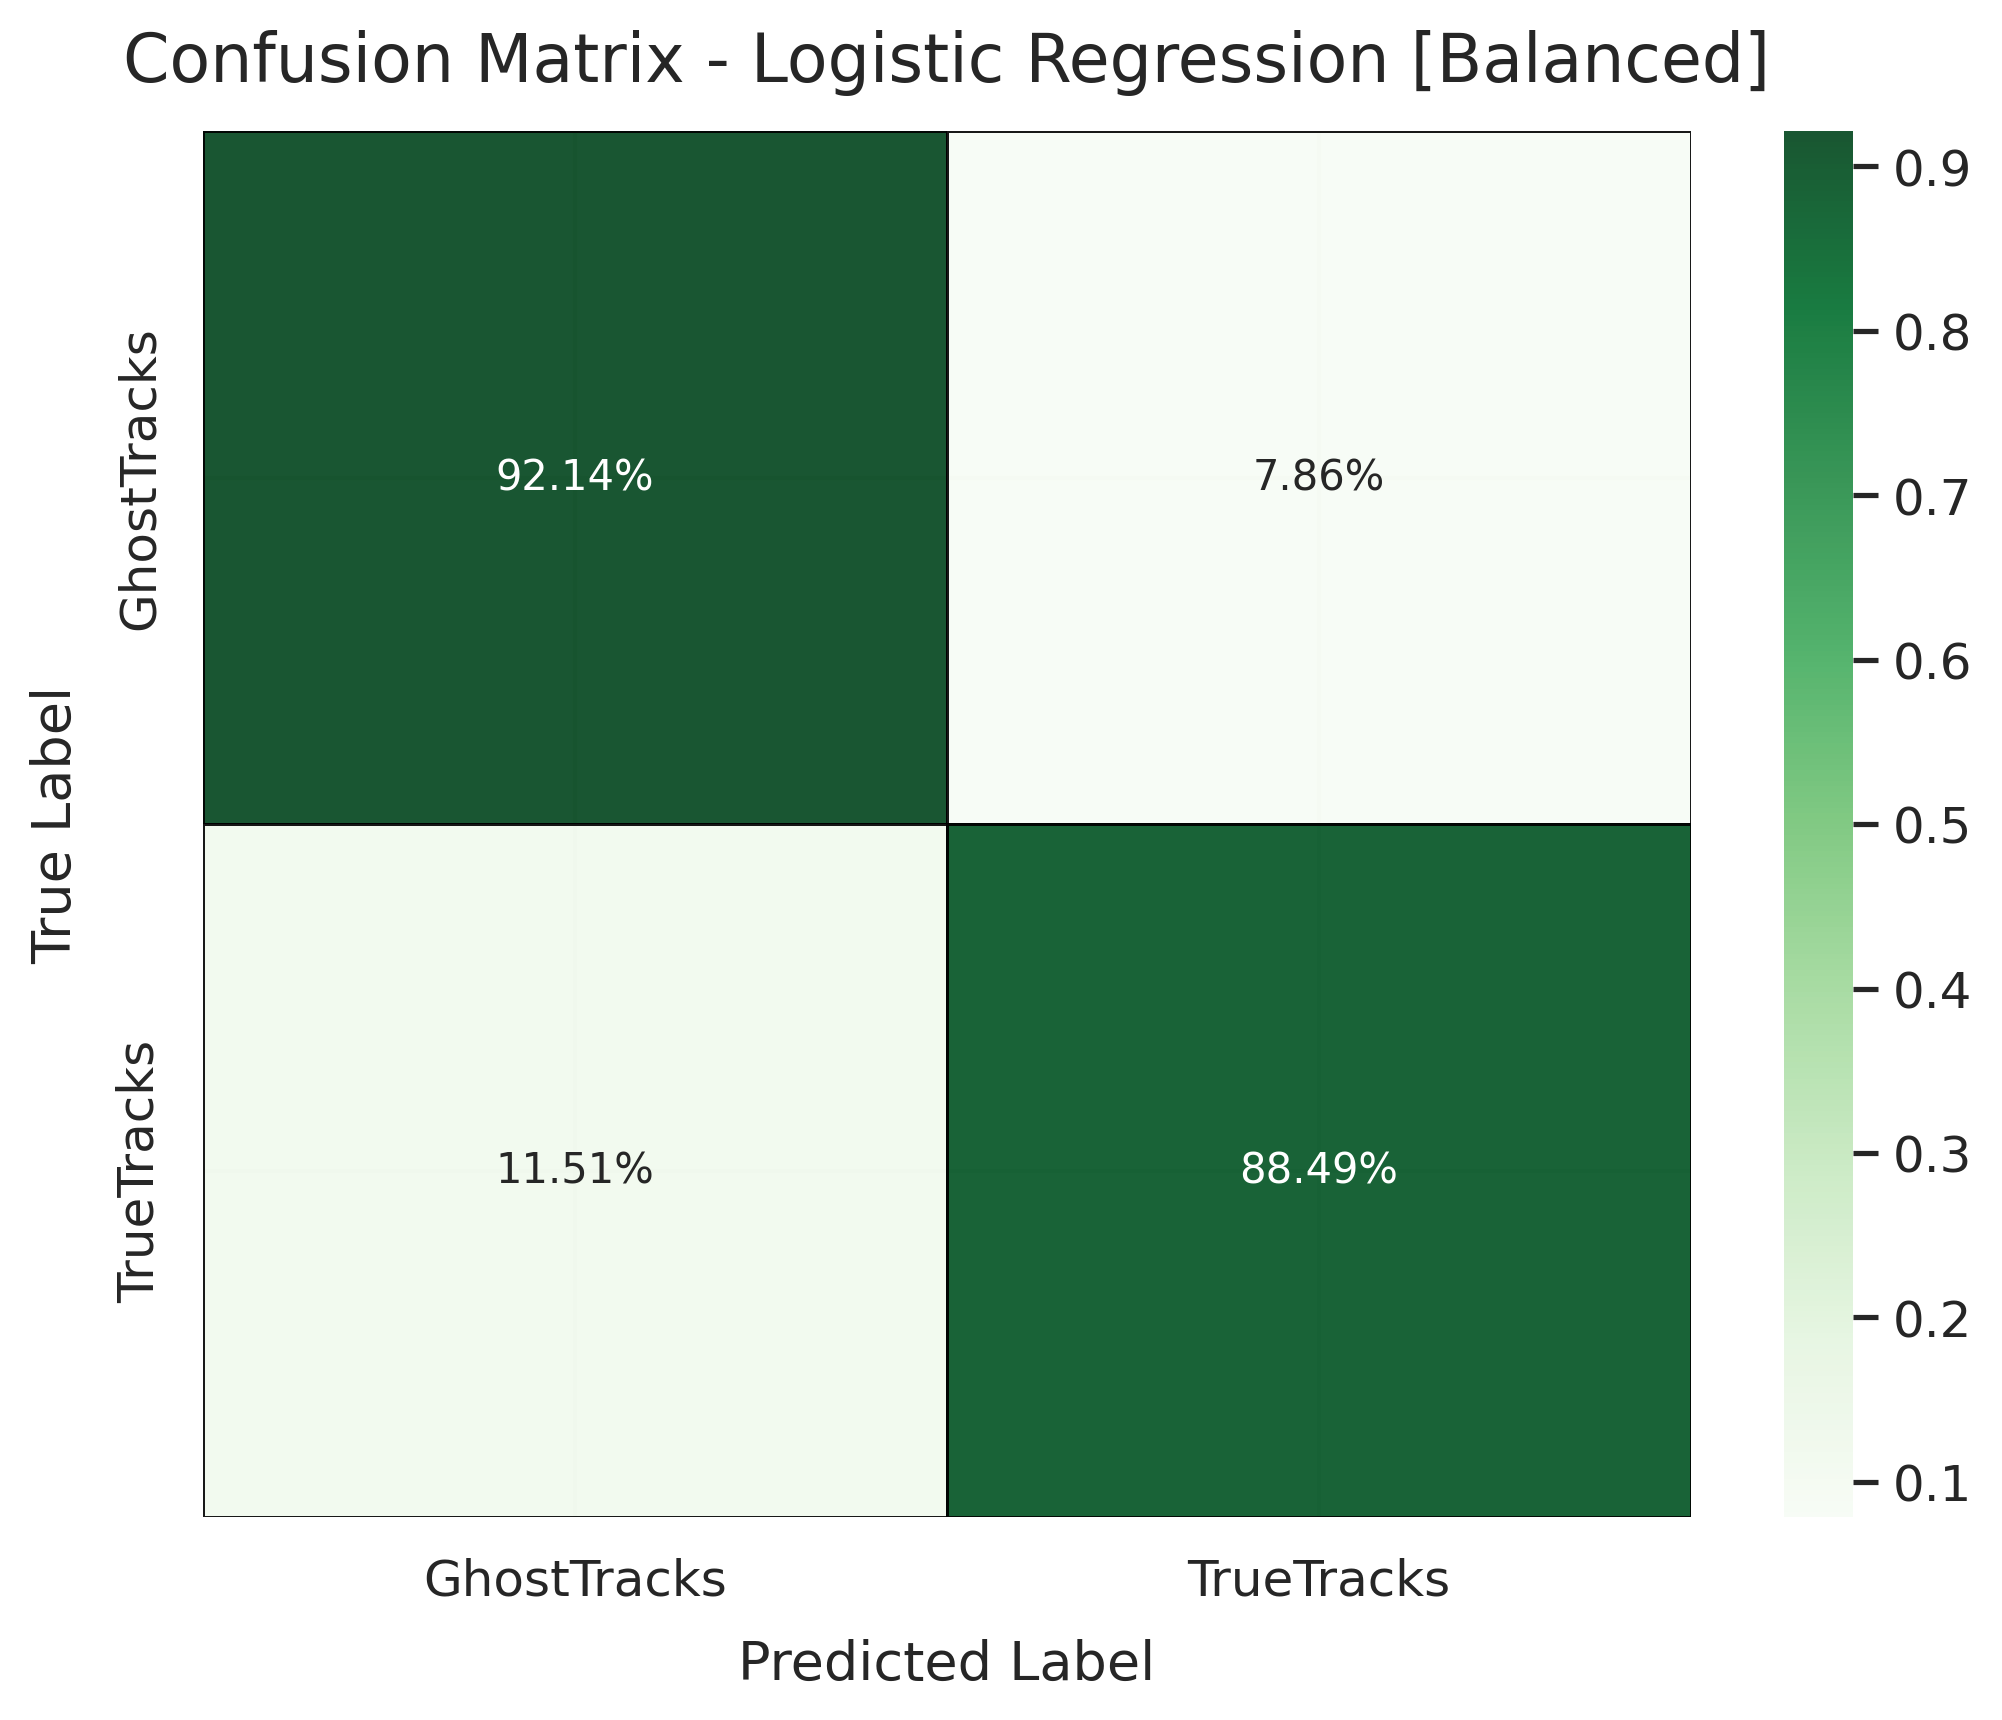

In [11]:
# ConfusionMatrix Test - Unbalanced

y_predict = model.predict(x_eval)

print("ROC-Score:", round(roc_auc_score(y_eval,y_predict)*100,2),"%")
print("F1-Score:", round(f1_score(y_eval,y_predict)*100,2),"%")
plt.figure(figsize=(8,6))
sns.heatmap(confusion_matrix(y_eval, y_predict,normalize='true'), xticklabels=['GhostTracks', 'TrueTracks'],yticklabels=['GhostTracks', 'TrueTracks'], fmt='.2%',annot=True, annot_kws={'fontsize': 10}, 
            cmap='Greens',linewidths=0.7,linecolor='black',alpha=0.9)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix - Logistic Regression [Balanced]')
plt.savefig(f"{figure_directory}/SciFi_Logit_CM_Balanced.png")
plt.show()


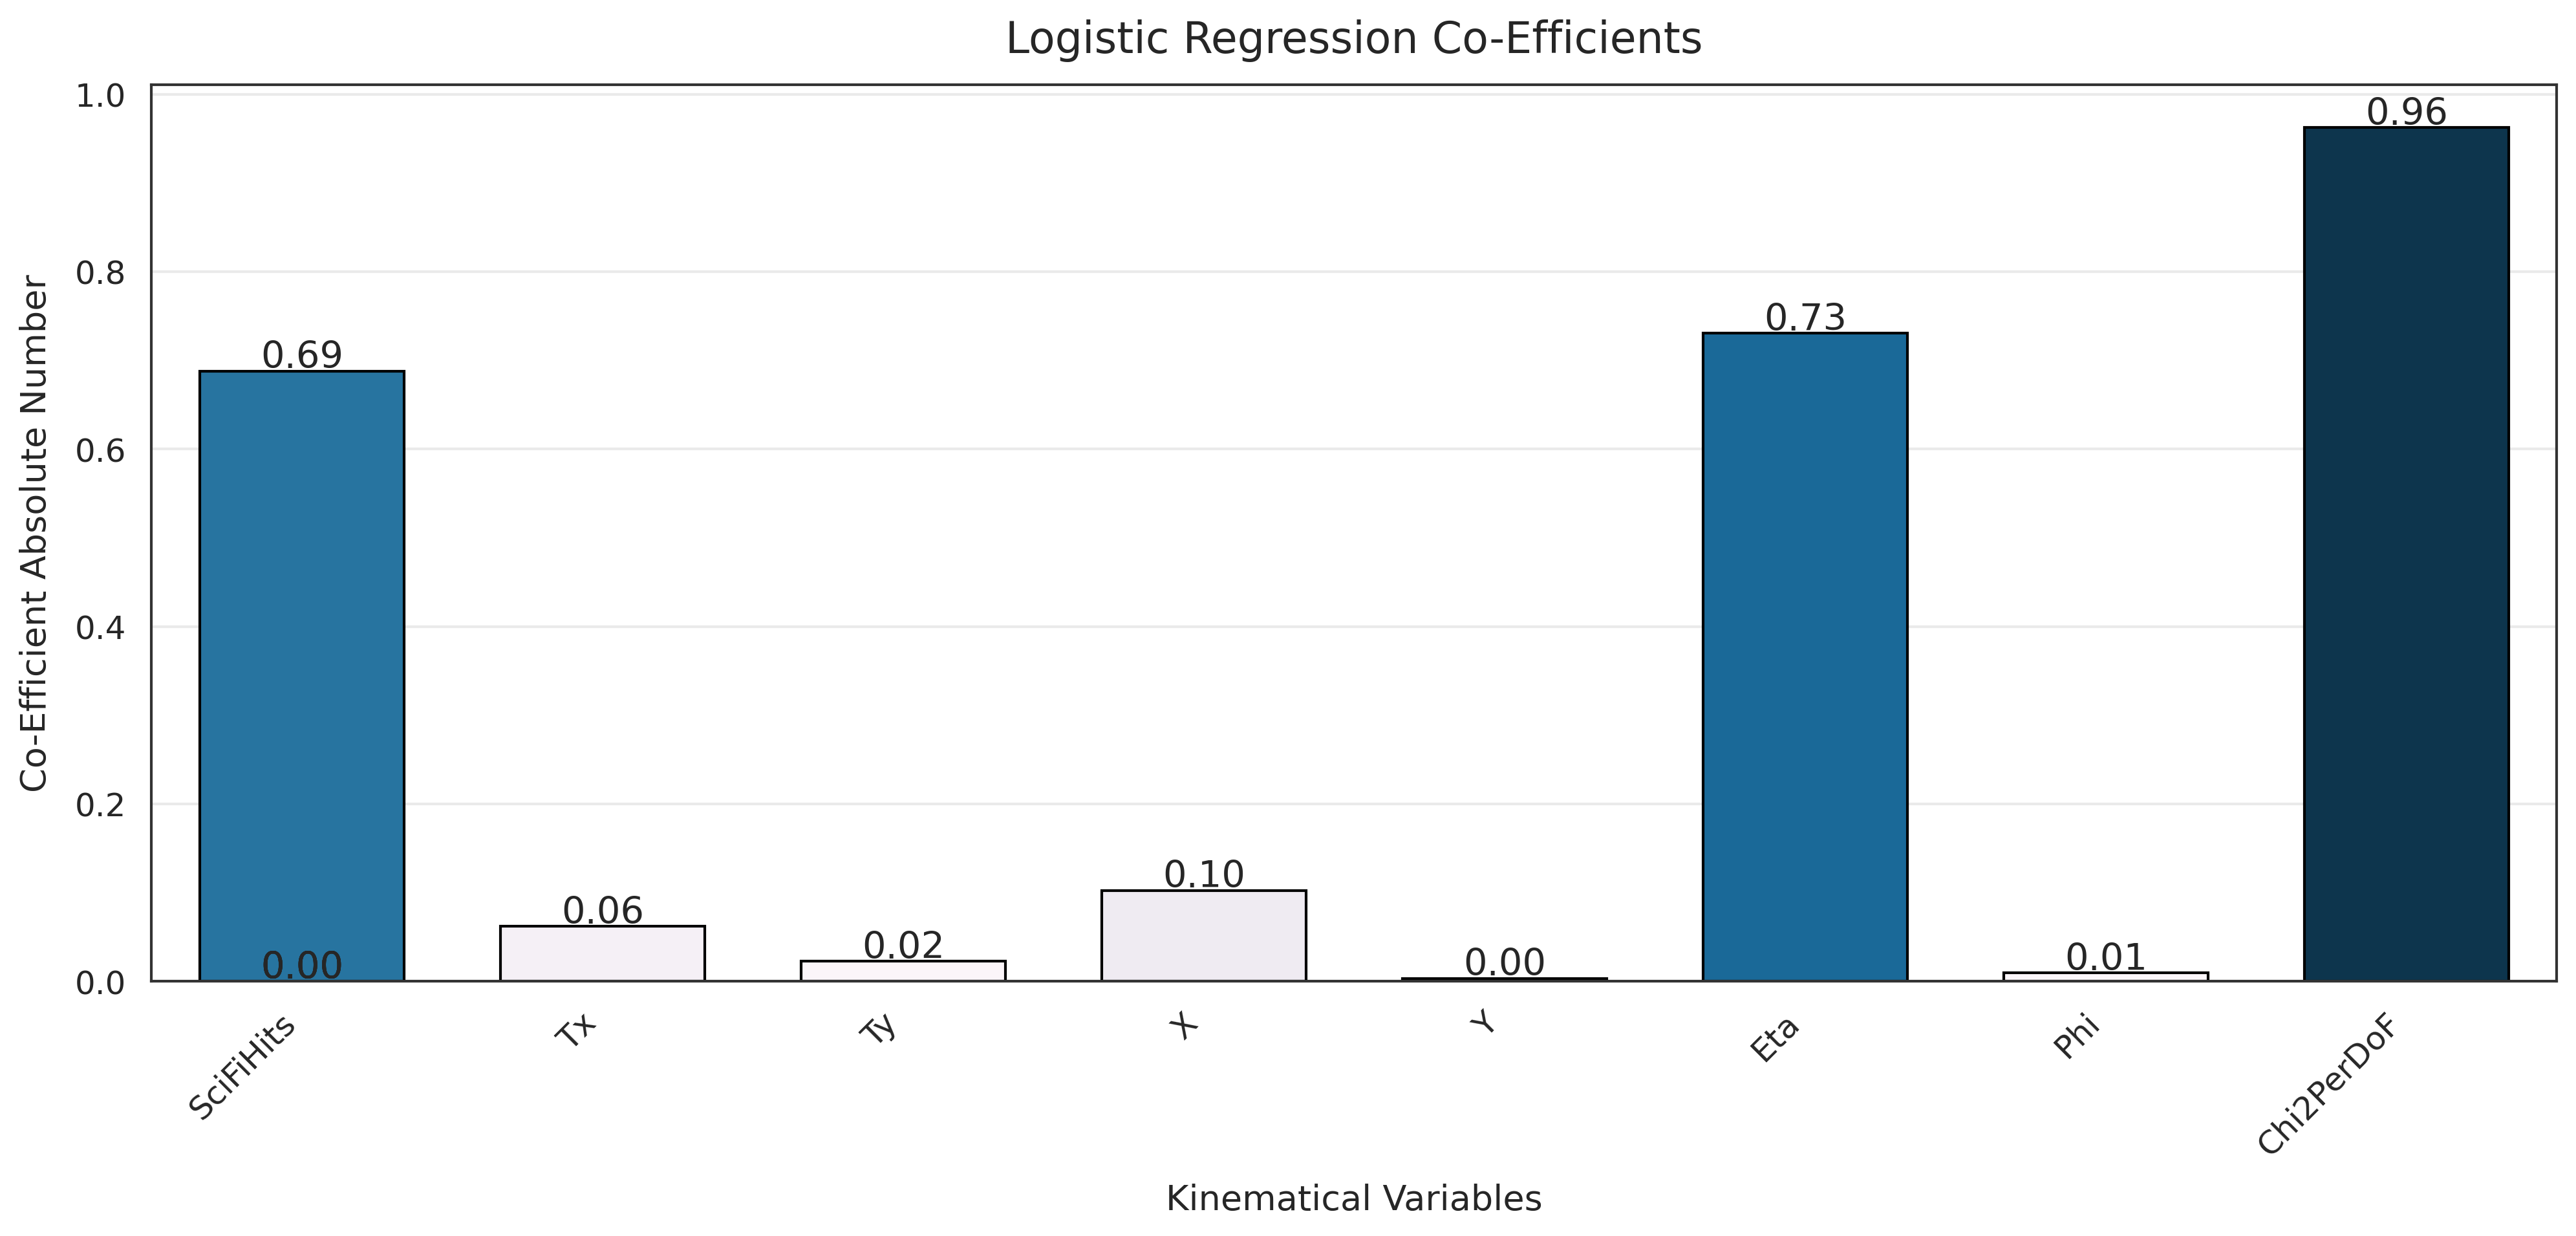

In [12]:
# Co-Efficients Absolute Values - Importance
plt.figure(figsize=(16, 6))
featureImportance = np.abs(model.coef_ [0]/ np.sum(model.coef_[0]))

ax=sns.barplot(x=columns, y=featureImportance,hue=np.abs(model.coef_[0]),edgecolor='black',palette='PuBu',gap=0.15)
for p in ax.patches:
    ax.annotate(format(p.get_height(), '.2f'), 
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha = 'center', va = 'center', 
                xytext = (0, 5), 
                textcoords = 'offset points')
plt.title('Logistic Regression Co-Efficients')
plt.xticks(rotation=45, ha='right')
plt.xlabel('Kinematical Variables')
plt.ylabel('Co-Efficient Absolute Number')
ax.legend_.remove()
plt.savefig(f"{figure_directory}/SciFi_Logit_FI.png")
plt.show()

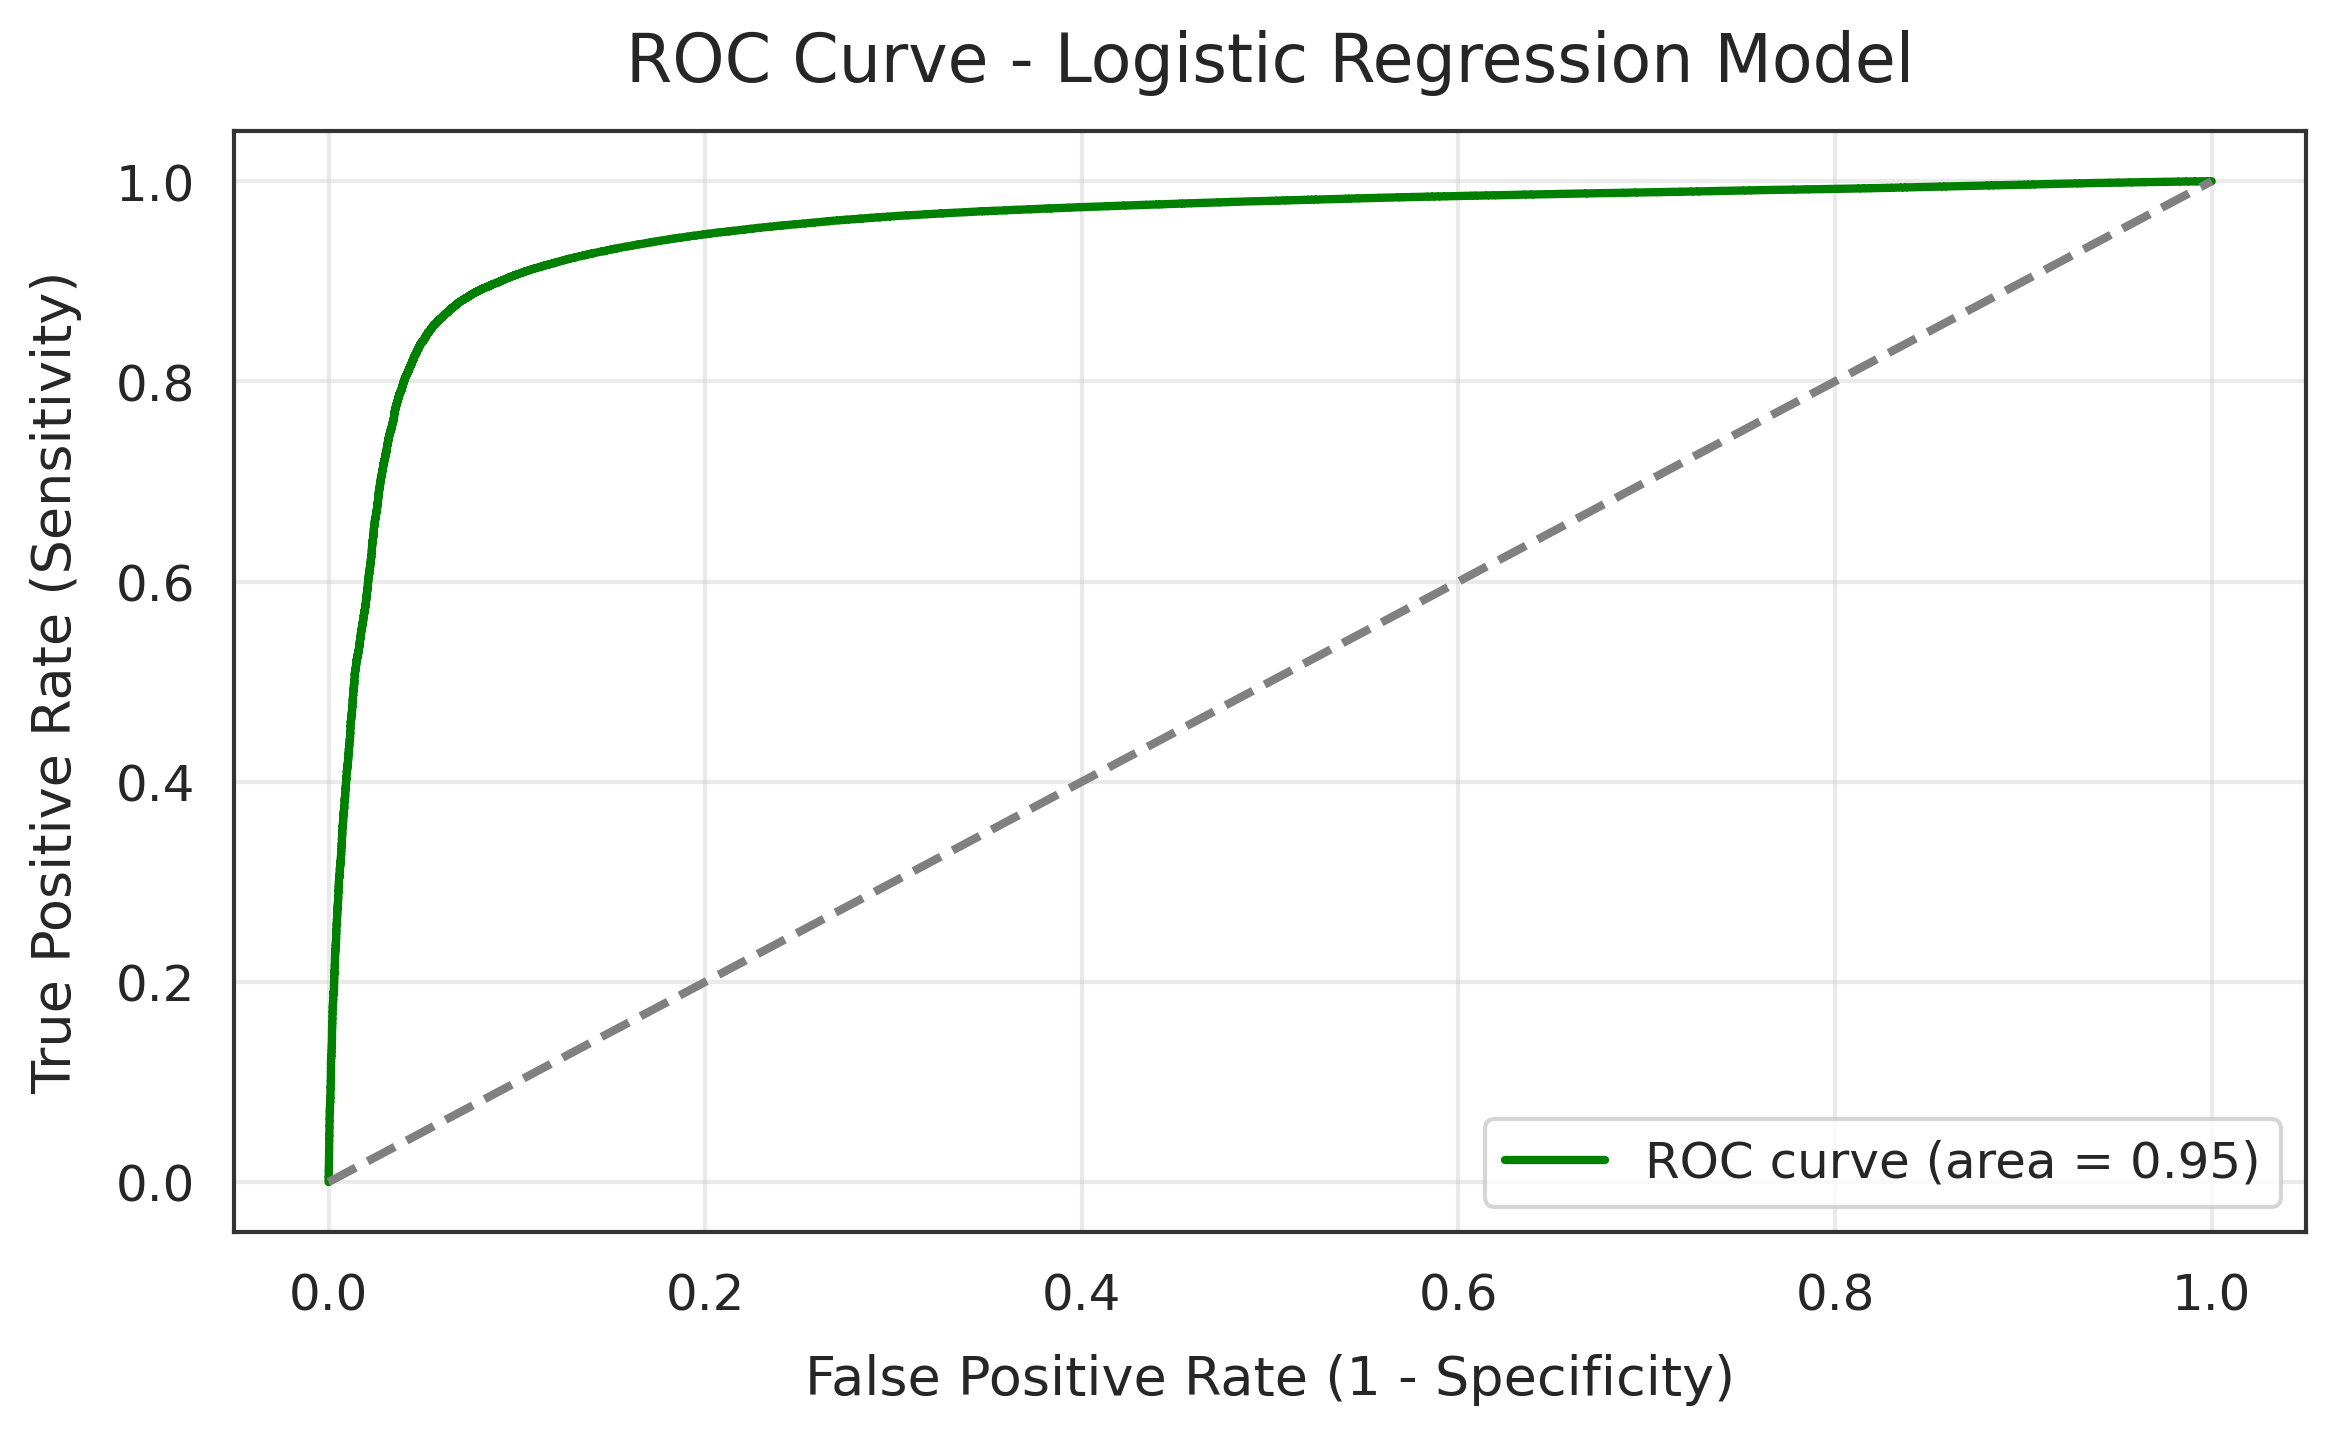

In [13]:
evaluation=x_test.copy()

probabilityValue = model.predict_proba(evaluation)[:,1] #First Probability will make the plot upside down
fpr, tpr, threshold =roc_curve(y_test,  probabilityValue)

plt.figure(figsize=(8, 5))
plt.title('ROC Curve - Logistic Regression Model')
plt.plot(fpr, tpr,color='Green',label='ROC curve (area = %0.2f)' % auc(fpr, tpr))
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.ylabel('True Positive Rate (Sensitivity)')
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.grid(True)
plt.tight_layout()
plt.legend()
plt.savefig(f"{figure_directory}/SciFi_Logit_ROC.png")
plt.show()

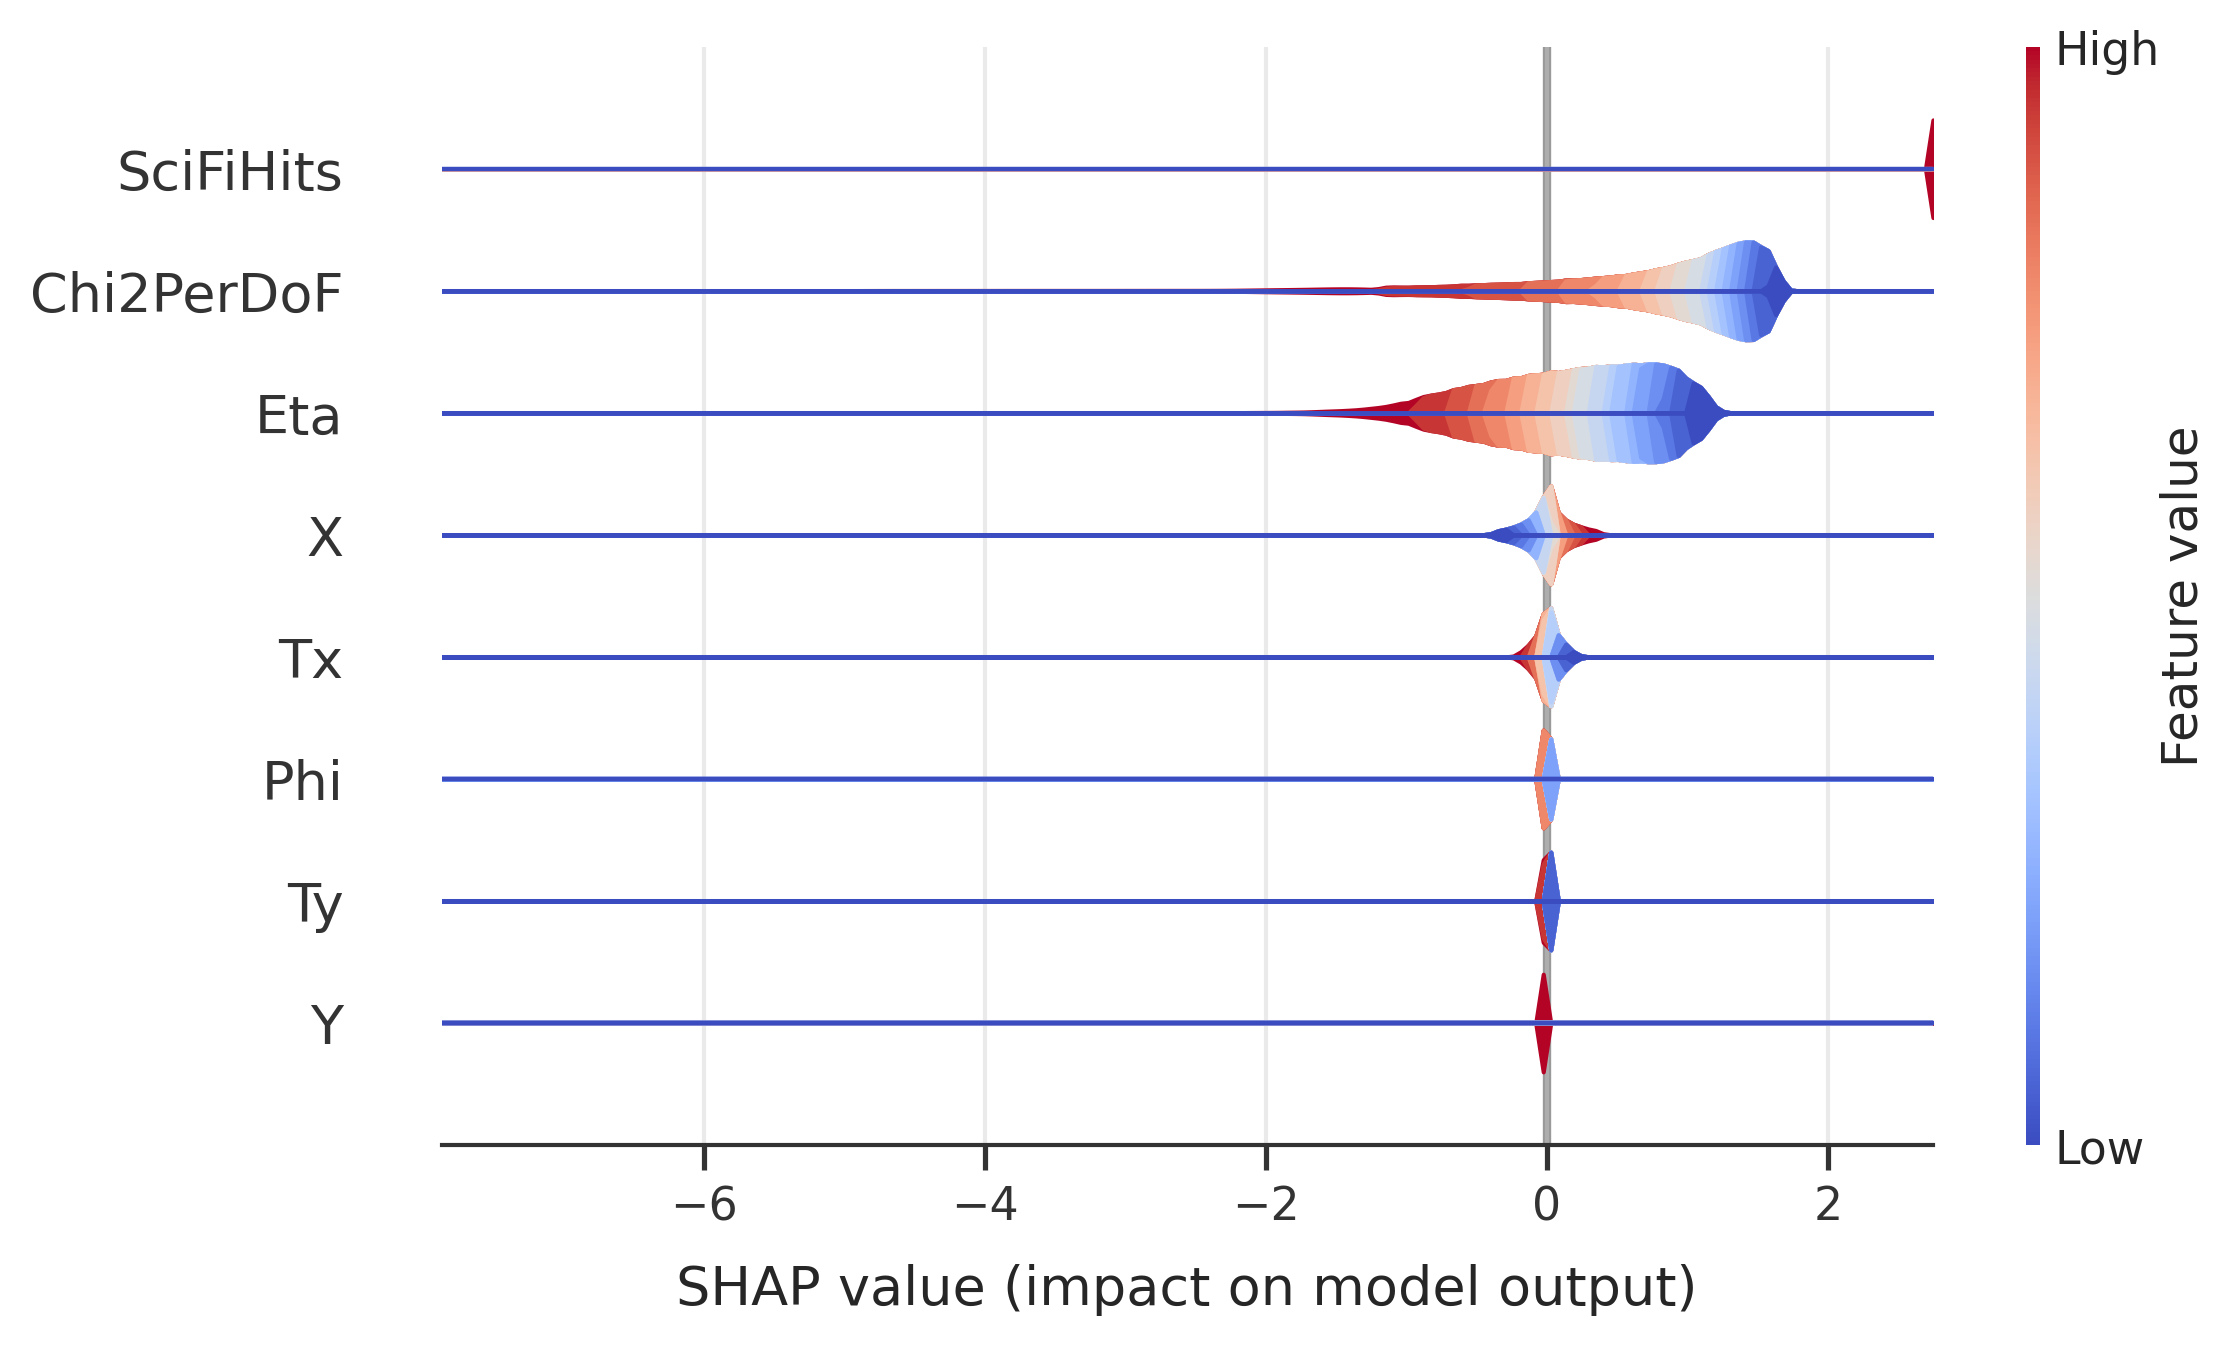

In [14]:
#Shap Evaluation
explainer = shap.LinearExplainer(model,masker=x_train, feature_perturbation="interventional")
shap_values = explainer.shap_values(x_test)
shap.summary_plot(shap_values, x_test, plot_type='layered_violin',show=False)
plt.savefig(f"{figure_directory}/SciFi_Logit_SHAP.png")


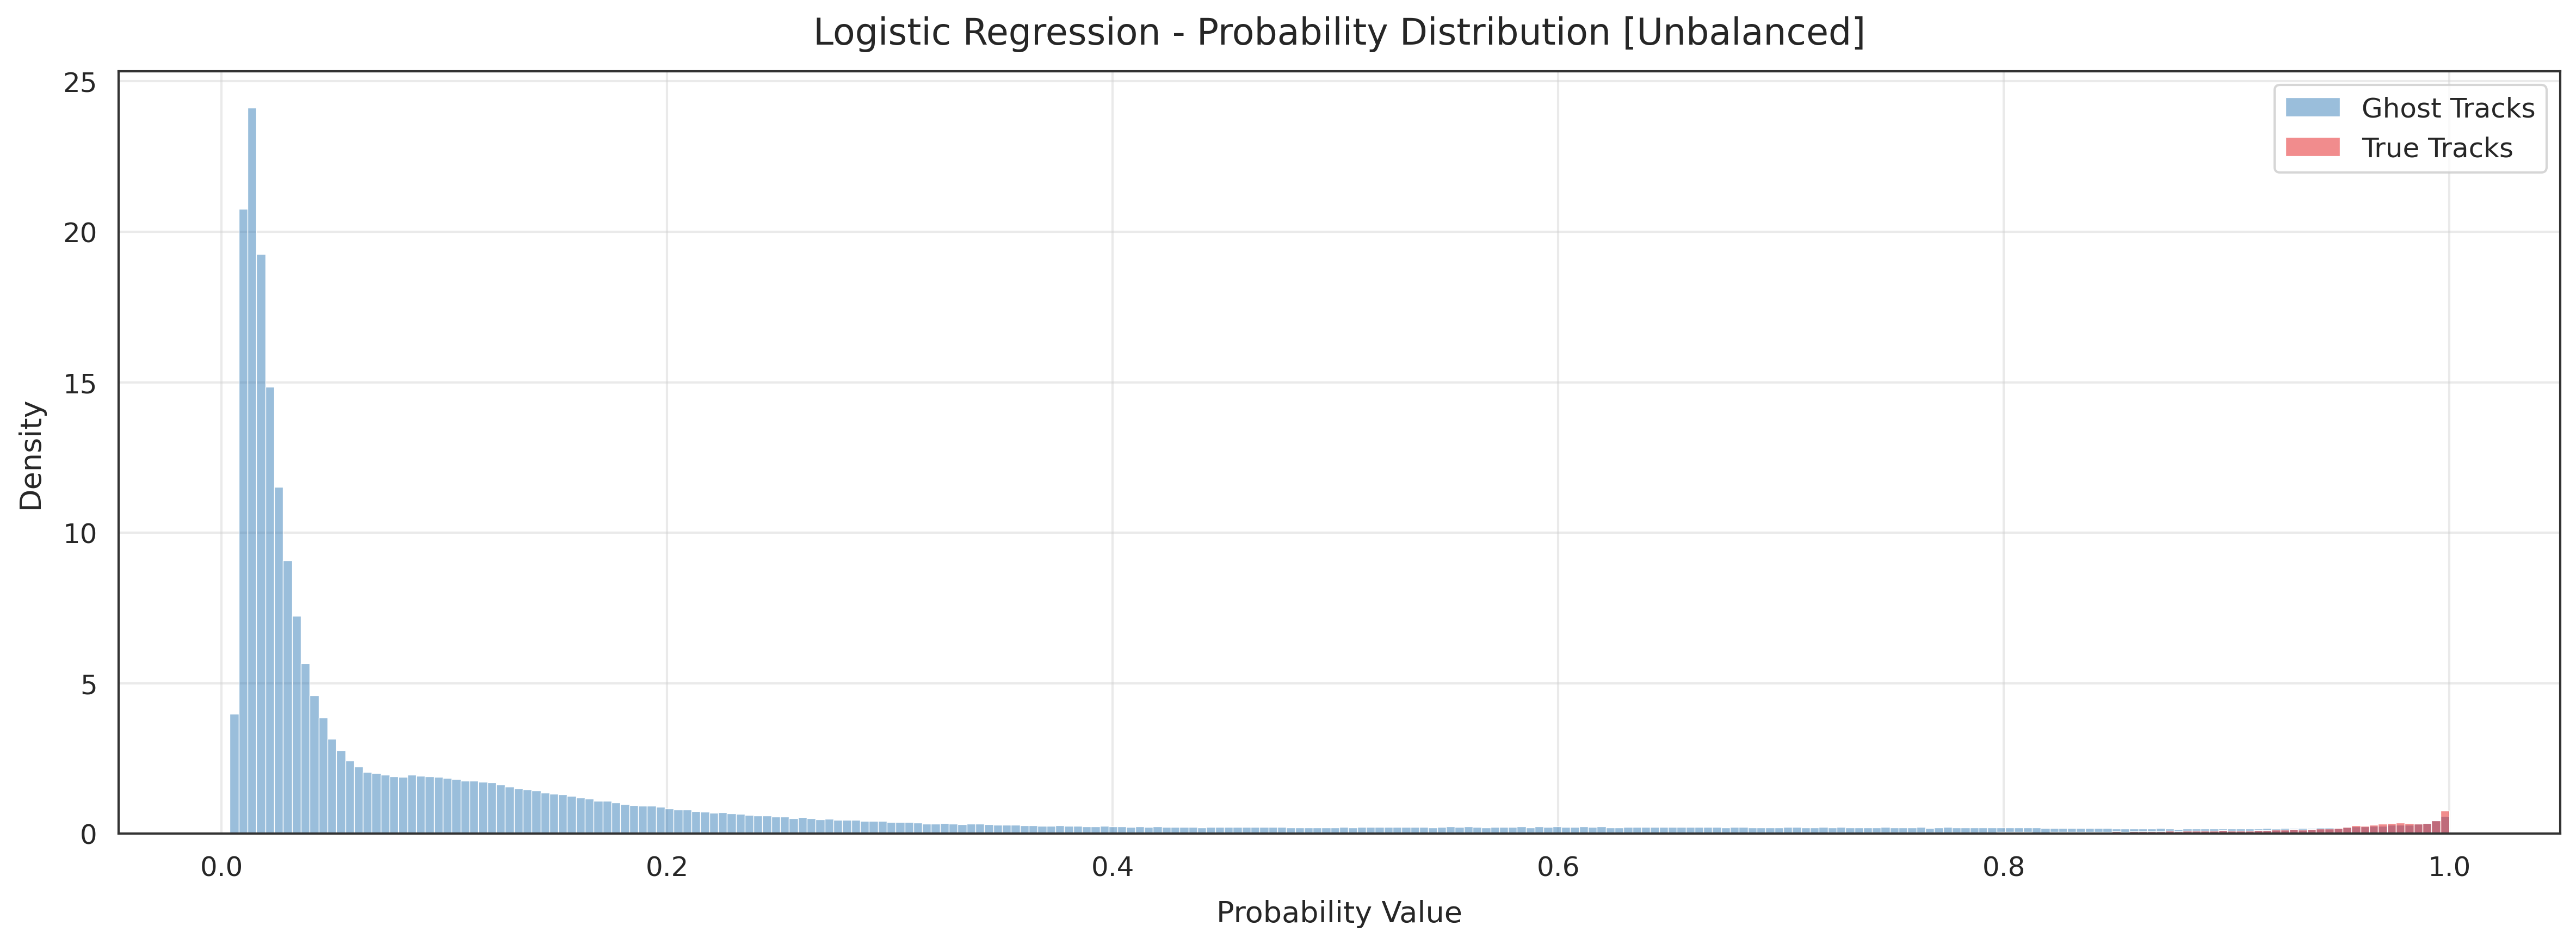

In [15]:
evaluation=x_test.copy()

probabilityValue = model.predict_proba(evaluation)[:,0] #Keeping the first set of probability for the distribution analysis
evaluation['ProbabilityValues']=probabilityValue
evaluation['TrueLabels']=y_test.values

plt.figure(figsize=(16, 6))
plt.title('Logistic Regression - Probability Distribution [Unbalanced]')
sns.histplot( x=evaluation['ProbabilityValues'], hue=evaluation['TrueLabels'], stat='density', bins=250, palette='Set1')
plt.xlabel('Probability Value')
plt.legend(labels=['Ghost Tracks', 'True Tracks'])

plt.savefig(f"{figure_directory}/SciFi_Logit_ProbDist_Unbalanced.png")
plt.tight_layout()
plt.show()

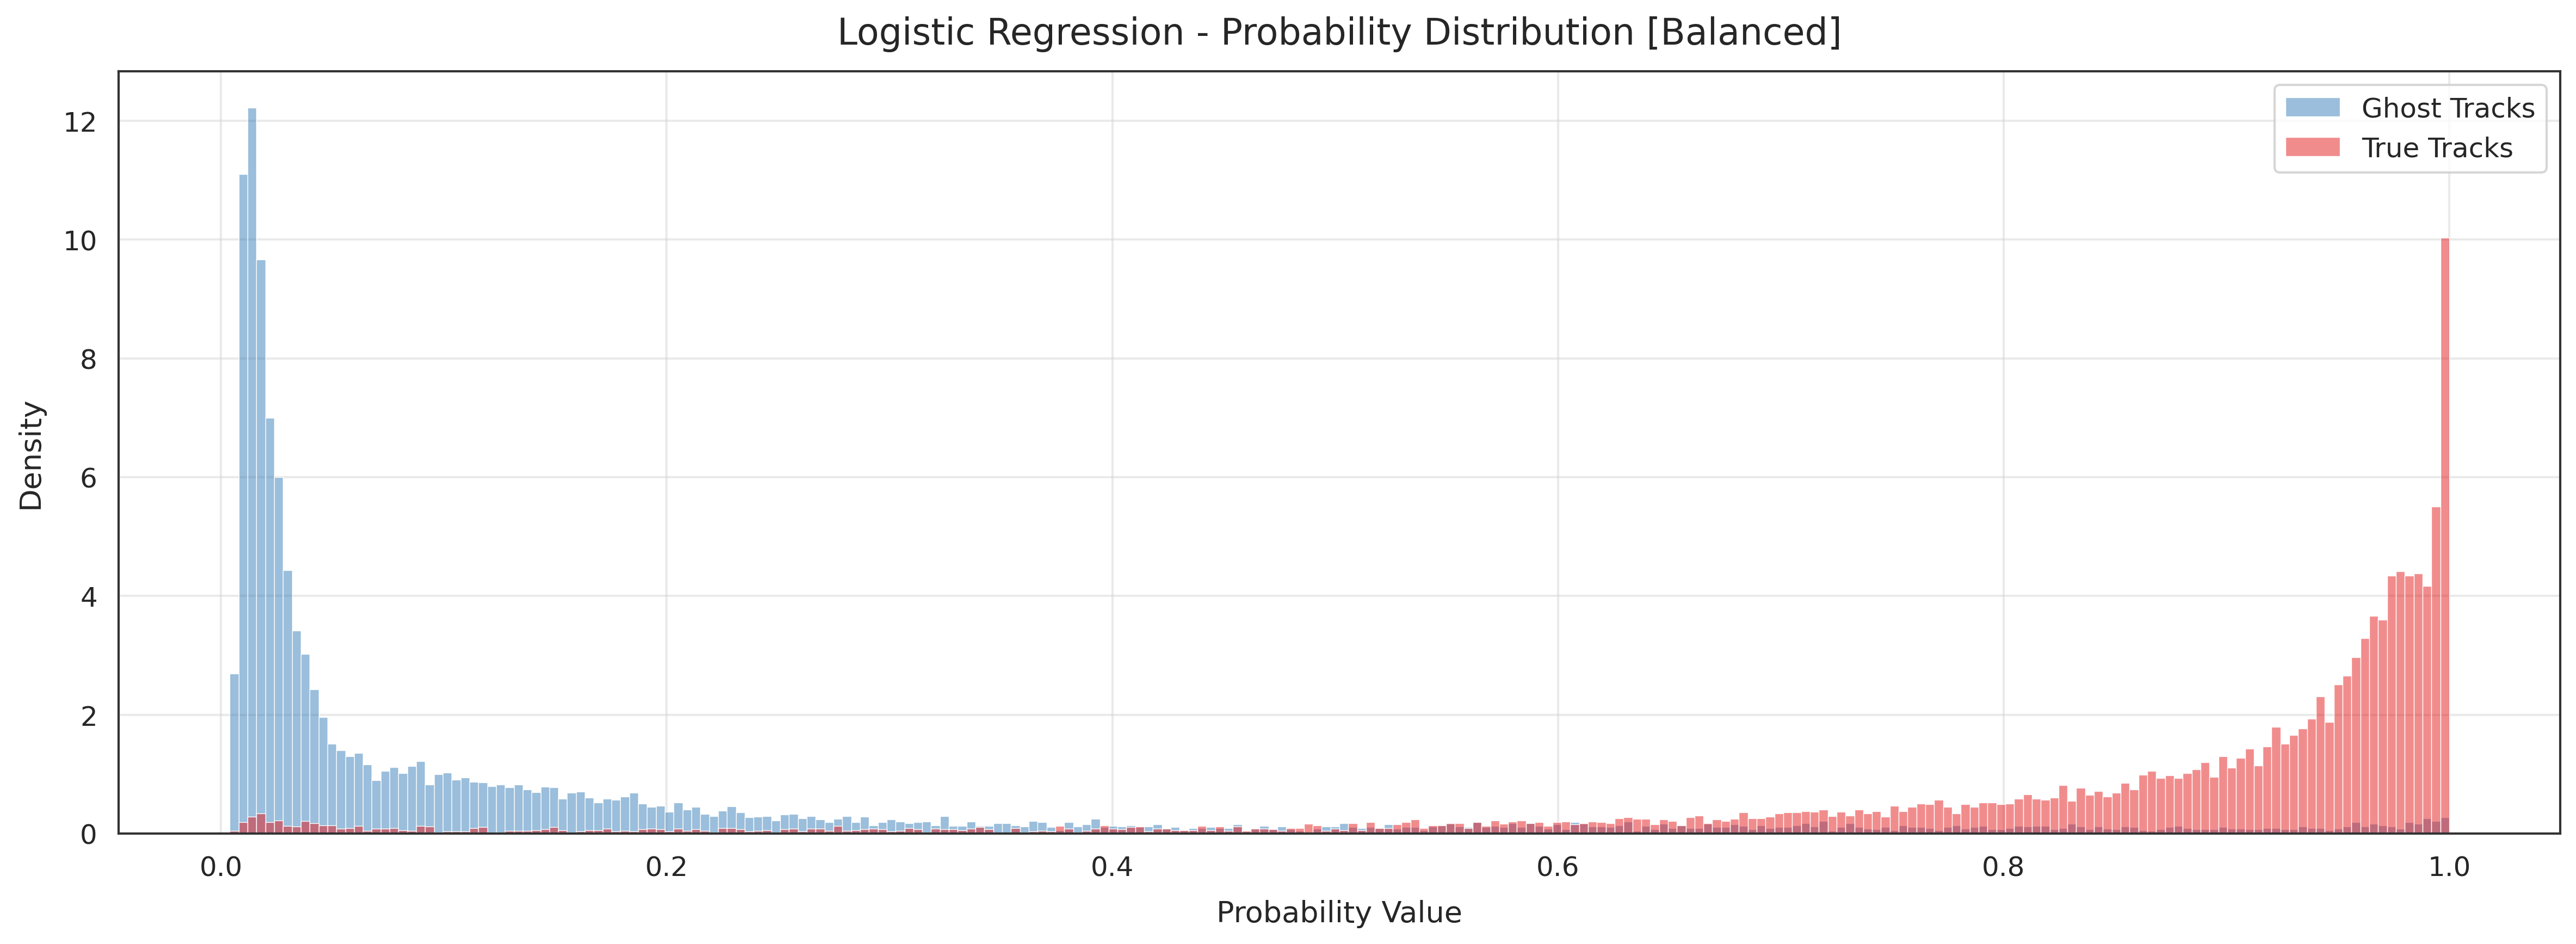

In [16]:
evaluation=x_eval.copy()

probabilityValue = model.predict_proba(evaluation)[:,0] #Keeping the first set of probability for the distribution analysis
evaluation['ProbabilityValues']=probabilityValue
evaluation['TrueLabels']=y_eval.values

plt.figure(figsize=(16, 6))
plt.title('Logistic Regression - Probability Distribution [Balanced]')
sns.histplot( x=evaluation['ProbabilityValues'], hue=evaluation['TrueLabels'], stat='density', bins=250, palette='Set1')
plt.xlabel('Probability Value')
plt.legend(labels=['Ghost Tracks', 'True Tracks'])
plt.savefig(f"{figure_directory}/SciFi_Logit_ProbDist_Balanced.png")
plt.tight_layout()
plt.show()

In [17]:
# Manual Calculations.

In [18]:
#Co-Efficients and Y Intercept
print("Coefficients:", model.coef_)
print("Intercept:", model.intercept_)

Coefficients: [[ 6.87180821 -0.6169226  -0.22546464  1.02248668 -0.03277224 -7.30013828
  -0.09277777 -9.61575372]]
Intercept: [-1.13861667]


In [19]:
# Picking a True Track and a Ghost Track.
data_scaled=pd.DataFrame(scaler.fit_transform(data),columns=data.columns)
data_true=data[data['isMatched']==1].iloc[0:1]
data_true_processed=data_scaled[data_scaled['isMatched']==1].iloc[0:1]

data_ghost=data[data['isMatched']==0].iloc[2:3]
data_ghost_processed=data_scaled[data_scaled['isMatched']==0].iloc[2:3]

In [20]:
# Reading and Displaying Picked Tracks, Actual Data and Processed Data

display("TrueTracks:",data_true)
print("---")
display("TrueTracksProcessed:",data_true_processed)
print("---")
display("GhostTracks:",data_ghost)
print("---")
display("GhostTracksProcessed:",data_ghost_processed)
print("---")

'TrueTracks:'

,nFTHits,tx,ty,ovtx_x,ovtx_y,eta,phi,chi2perdof,isMatched
0,12,-0.268153,0.021381,-1055.345947,173.193176,2.023796,3.062026,0.294202,True


---


'TrueTracksProcessed:'

,nFTHits,tx,ty,ovtx_x,ovtx_y,eta,phi,chi2perdof,isMatched
0,1.0,0.368795,0.515675,0.300566,0.542874,0.124055,0.987337,0.05861,1.0


---


'GhostTracks:'

,nFTHits,tx,ty,ovtx_x,ovtx_y,eta,phi,chi2perdof,isMatched
169,11,-0.125859,0.065148,-240.964371,520.567749,2.652025,2.663943,0.229126,False


---


'GhostTracksProcessed:'

,nFTHits,tx,ty,ovtx_x,ovtx_y,eta,phi,chi2perdof,isMatched
169,0.666667,0.434712,0.570518,0.454621,0.626228,0.187841,0.92398,0.045591,0.0


---


In [21]:
# Building Manual Calculation Table.
desc_=pd.DataFrame(columns,columns=['Features'])
desc_['TrueTrack']=data_true.drop(['isMatched'],axis=1).values[0]
desc_['TrueTrackProcessed']=data_true_processed.drop(['isMatched'],axis=1).values[0]
desc_['GhostTrack']=data_ghost.drop(['isMatched'],axis=1).values[0]
desc_['GhostTrackProcessed']=data_ghost_processed.drop(['isMatched'],axis=1).values[0]
desc_['Co-Effs']=model.coef_[0]

desc_['True-Eff']=desc_['TrueTrackProcessed']*desc_['Co-Effs']
desc_['Ghost-Eff']=desc_['GhostTrackProcessed']*desc_['Co-Effs']
desc_

,Features,TrueTrack,TrueTrackProcessed,GhostTrack,GhostTrackProcessed,Co-Effs,True-Eff,Ghost-Eff
0,SciFiHits,12.000000,1.000000,11.000000,0.666667,6.871808,6.871808,4.581205
1,Tx,-0.268153,0.368795,-0.125859,0.434712,-0.616923,-0.227518,-0.268184
2,Ty,0.021381,0.515675,0.065148,0.570518,-0.225465,-0.116267,-0.128632
3,X,-1055.345947,0.300566,-240.964371,0.454621,1.022487,0.307325,0.464844
4,Y,173.193176,0.542874,520.567749,0.626228,-0.032772,-0.017791,-0.020523
5,Eta,2.023796,0.124055,2.652025,0.187841,-7.300138,-0.905617,-1.371266
6,Phi,3.062026,0.987337,2.663943,0.923980,-0.092778,-0.091603,-0.085725
7,Chi2PerDoF,0.294202,0.058610,0.229126,0.045591,-9.615754,-0.563581,-0.438396


In [22]:
# Following the Equation Y = MX + C

y_ValTrue=desc_['True-Eff'].sum()+model.intercept_[0]

y_ValGhost=desc_['Ghost-Eff'].sum()+model.intercept_[0]

In [23]:
# Y Value and the Logit Value (Probability - True Tracks)
print("Y- Value :",y_ValTrue)
logit(y_ValTrue)

Y- Value : 4.11814029573216
Probability Value: 0.9839858734045002


In [24]:
# Y Value and the Logit Value (Probability - Ghost Tracks)
print("Y- Value :",y_ValGhost)
logit(y_ValGhost)

Y- Value : 1.5947078197192897
Probability Value: 0.8312774297460724


In [25]:
##End of Notebook